# Dimensionality Reduction

In this notebook, I will propose and emply two dimensionality reduction tecniques to my data

Currently, the dataset is quite large. With 54 years and 12 months/year, the time dimension is reasonable. However, having lat/lon data at 0.5 degree increments (in current configuration) pushes the data into millions or tens of millions of datapoints, depending on the exact configuration. Reducing the dimensisonality in ways that preserves the critical information will be very helpful for speeding interpretation.

## Import packages
Gotta get this out of the way

In [280]:
# import packages - general
import numpy as np
import pandas as pd

# import packages - geospatial
import xarray as xr

# import packages - plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import packages - PCA and ICA
from sklearn.decomposition import PCA
from scipy import signal
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler

## Inputs

Set basic parameters about how the script will run


In [281]:
# set lists of coordinates and time ranges (pulled from Prepare_AI_Ready_Data.py) (CURRENTLY JUST ONE, BUT CAN ADD MORE)
coords = [[180,240,45,65]]
times = [['1970-01-01','2023-12-31']]  # Ensure the time range is valid

# select which of the list I want to load
coords_num = 0
times_num = 0

## Import data  
Note that I set this up to be able to load different datasets as I wish, given my plan to explore multiple different datasets

In [282]:
# set the path to the data
path_to_ready = '../data/ai_ready/'

# pull the correct coordinate and time (as set above)
c = coords[coords_num]
t = times[times_num]

# set filename
filename = f"era5_subset_{c[0]}-{c[1]}_{c[2]}-{c[3]}_{t[0][:4]}-{t[1][:4]}.nc"

# load data
ds = xr.open_dataset(path_to_ready+filename)

## Dimension Reduction #1 - PC Analysis

### Part 1 - Preform the PC

First up, I'm opting to reduce the dimensionality of the dataset with principal component analysis. This unsupervised learning technique will let me pick out the key elements of varability across all of the data variables (and how they interact) in a much more compact format.

In [283]:

# Extract the data variables
sst_array = ds['sst'].values
msl_array = ds['msl'].values
sp_array = ds['sp'].values

# extract lat and lon (used for plotting)
lat = ds['latitude'].values
lon = ds['longitude'].values

# extract time (used for plotting). Convert the datatime64 to integer years
time = np.array(ds['time'].values)


# Reshape the data to have time as rows and the flattened lat/lon as columns
n_time = sst_array.shape[0]
n_lat = sst_array.shape[1]
n_lon = sst_array.shape[2]

# Reshape the data to have time as rows and the flattened lat/lon as columns
sst = sst_array.reshape(n_time, -1)
msl = msl_array.reshape(n_time, -1)
sp = sp_array.reshape(n_time, -1)

# filter out nan values from sst
idx = ~np.isnan(sst[0,:])
sst = sst[:,idx]
len_sst = len(sst[0,:])

# Combine the data into a single array
data = np.concatenate([sst, msl, sp], axis=1)

# Perform PCA
pca = PCA(n_components=10)  # You can adjust the number of components
principal_components = pca.fit_transform(data)

### Explore explained variance

I was thourough and plotted a large number of PCs (10). However, we can see that almost 60% of the variance is explained by the first PC, almost 80% by the first two, and almost 90% by the first three. The first one is clearly the most significant, but the next two also seem somewhat important.

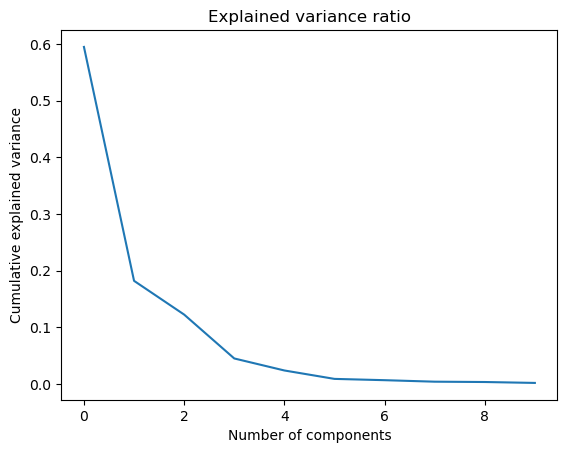

Explained variance ratio: [0.5948938  0.18184541 0.12224546 0.04477394 0.02356225 0.0086913
 0.0064044  0.00376172 0.00317958 0.00157465]


In [284]:
# Plot the explained variance ratio
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Explained variance ratio')
plt.show()

# Print the explained variance ratio
print("Explained variance ratio:", pca.explained_variance_ratio_)

### Plot timeseries

Below I plot each of the first three timeseires. The first shows a slightly increasing trend, but not overly signficant. All of the varaibility is very high frequency, without signficant autocorrelation and few excursions from the mean lasting more than a couple of months.

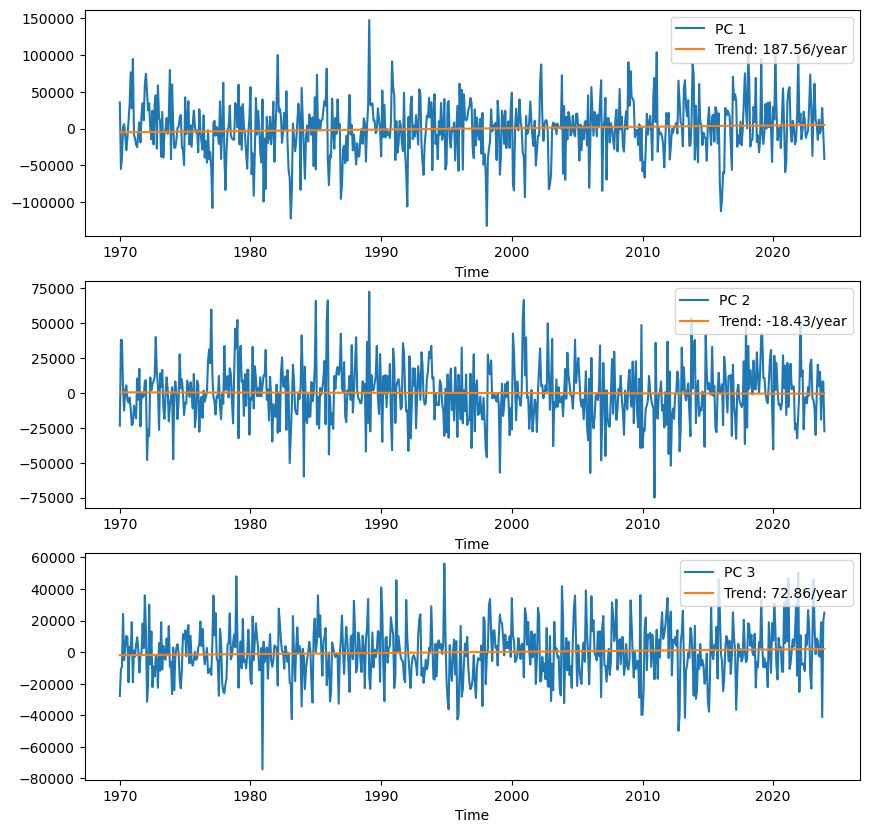

In [285]:
# Make figure
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Convert time to numerical format (years)
time_years = time.astype('datetime64[Y]').astype(int) + 1970

for i in range(3):
    ax[i].plot(time, principal_components[:, i], label=f'PC {i+1}')

    # Fit a line to the data and report the trend
    trend = np.polyfit(time_years, principal_components[:, i], 1)
    ax[i].plot(time, trend[0] * time_years + trend[1], label=f'Trend: {trend[0]:.2f}/year')

    ax[i].set_xlabel('Time')
    ax[i].legend(loc='upper right')

plt.show()

### Plot the first three principal components

As a climate scientist, I'm interested in what the physical meaning of the three PCs is. Thus, I'm going to plot the pattern they form.

This is actually kinda tricky to code, thanks to the fact that we've combined multiple datasets here and that the SST dataset has nan values. I think I found a relatively clean way to do it, but I'm sure there's a better one. Please suggest something!

We see the first EOF clearly represents the Aleutian Low (strong values = higher pressure = weak Aleutian Low). This seems to result in cooler SSTs along the coast.

The seccond EOF shows higher pressures to the east, and lower to the west. There's a major warming of SSTs in the coastal area of the Bering Sea.

The third EOF shows a general cooling pattern in the SSTs, and a high pressure anomaly to the south. This might represent a more southern expression of the Aleutian Low?

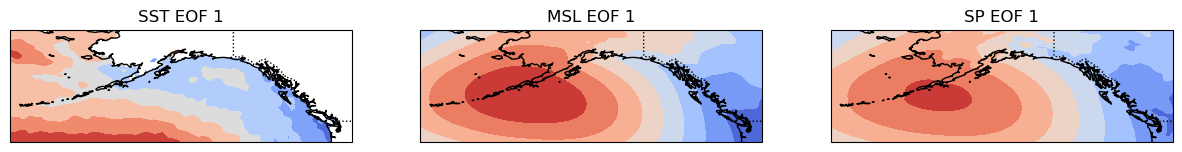

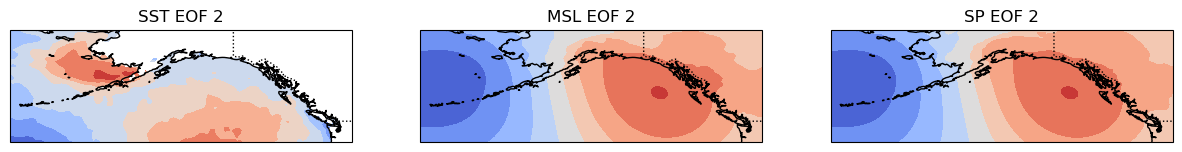

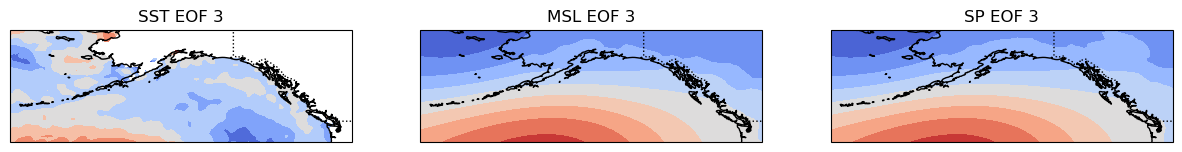

In [286]:
# pull out EOFs
eofs = pca.components_.reshape(10,2*n_lat*n_lon+len_sst,1)

# loop through the EOFs
for j in range(3):

    eof = eofs[j]

    # break out the eofs into different variables
    sst_eof_vector = np.reshape(eof[0:len_sst],(len_sst))
    sst_nan_vector = []
    cnt = 0
    for i in range(len(idx)):
        if idx[i]:
            sst_nan_vector.append(sst_eof_vector[cnt])
            cnt += 1
        else:
            sst_nan_vector.append(np.nan)
    sst_eof = np.reshape(np.array(sst_nan_vector),(n_lat,n_lon))
    msl_eof = np.reshape(eof[len_sst:len_sst+n_lat*n_lon],(n_lat,n_lon))
    sp_eof = np.reshape(eof[len_sst+n_lat*n_lon:],(n_lat,n_lon))

    eof_array = [sst_eof,msl_eof,sp_eof]
    labels = ['SST','MSL','SP']

    fig,ax = plt.subplots(1,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15,30))
    
    #fig,ax = plt.subplots(1,3,figsize=(12,22))

    for i in range(0,3):

        # make into xarray
        eof_xr = xr.DataArray(eof_array[i], coords=[lat, lon], dims=['latitude', 'longitude'])
        # plot the data
        ax[i].contourf(lon, lat, eof_array[i], cmap='coolwarm', transform=ccrs.PlateCarree())

        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        ax[i].add_feature(cfeature.COASTLINE)
        ax[i].add_feature(cfeature.BORDERS, linestyle=':')
        ax[i].set_title(labels[i]+f' EOF {j+1}')


    plt.show()



## Seccond Approach

For a seccond approach to reducing dimensionality, I'm going to try ICA. This might resolve more complex patterns. This might be neccisary given the noisy nature of this system. I'm going to start with assuming n=3 components, based on the PCA results, but will adjust that as needed.

We already have the data prepped from the PCA work. 

### Apply ICA

Below, I prep the data and apply the ICA.

In [287]:
# Center and whiten the data
scaler = StandardScaler()
data_whitened = scaler.fit_transform(data)

# Apply ICA
n_components = 3
ica = FastICA(n_components=n_components, random_state=0, max_iter=1000)
S_ = ica.fit_transform(data_whitened)  # Reconstructed signals
A_ = ica.mixing_  # Estimated mixing matrix

### Now we can plot the ICA timeseries

My main takaway here is that the first timeseries shows a strong increasing trend of 0.03 per year, with signfiicant variability. The seccond and third indepedent components show higher frequency variability with less of a trend.

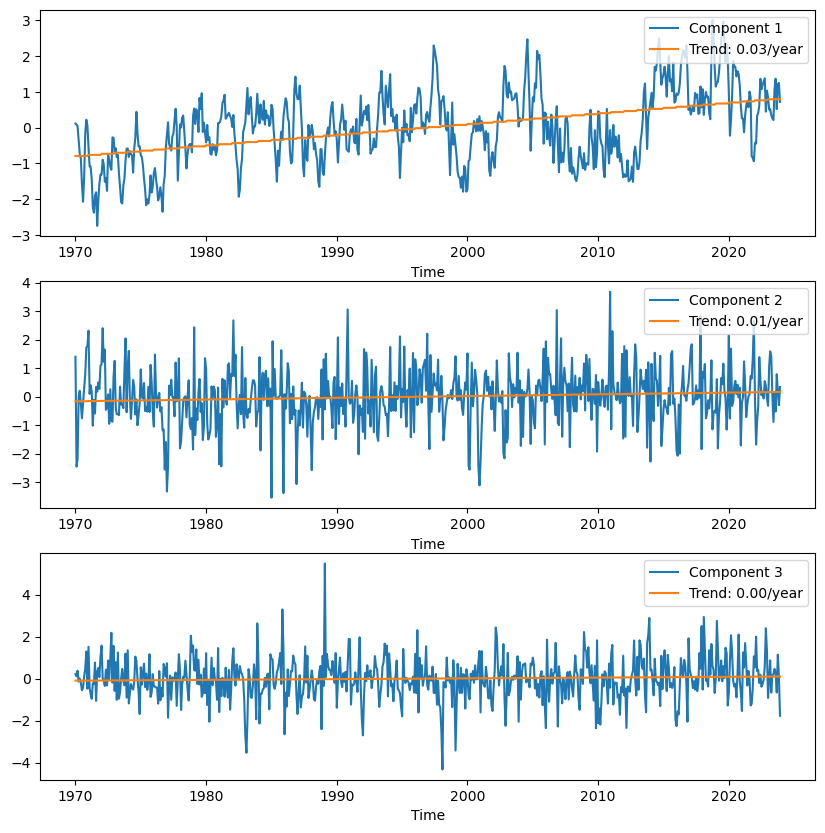

In [288]:
# make figure
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Convert time to numerical format (years)
time_years = time.astype('datetime64[Y]').astype(int) + 1970

for i in range(n_components):
    ax[i].plot(time, S_[:, i], label=f'Component {i+1}')

    # fit a line to the data and report the trend
    trend = np.polyfit(time_years, S_[:, i], 1)
    ax[i].plot(time, trend[0] * time_years + trend[1], label=f'Trend: {trend[0]:.2f}/year')

    ax[i].set_xlabel('Time')
    ax[i].legend(loc='upper right')


### Next up, we reshape the data back to the original shape and plot the ICA components

I reuse much of the code from the PCA analysis here.

The first IC shows up strongly in the SST dataset with a strong warming trend. This IC shows a consistent increase in the timeseries. I think this might represent a general global warming trend. It also includes a general increase in pressure over land and a decrease over the ocean.

The seccond IC is the inverse of the seccond PC above, particularly in the pressure fields.

The third IC shows a strong high pressure anomaly centered over the gulf of Alaska coast, with cooler SSTs in the gulf and warmer SSTs in the Bering Sea. I'm not sure of a simple climate story that maps to this IC.

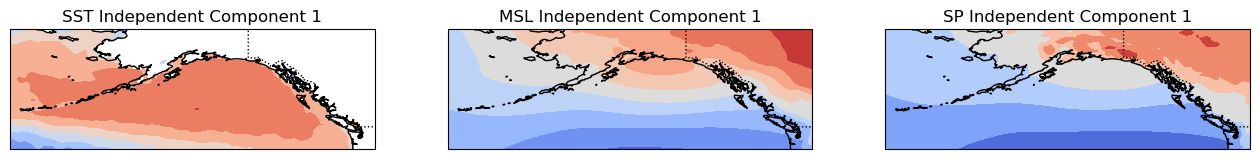

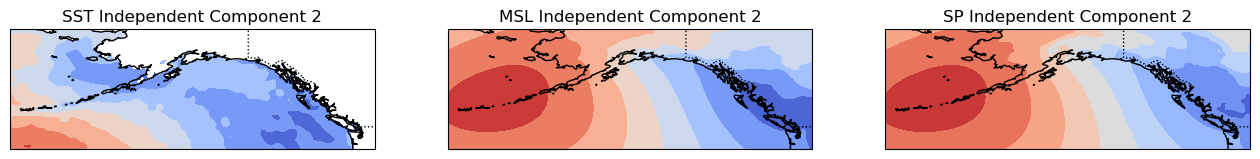

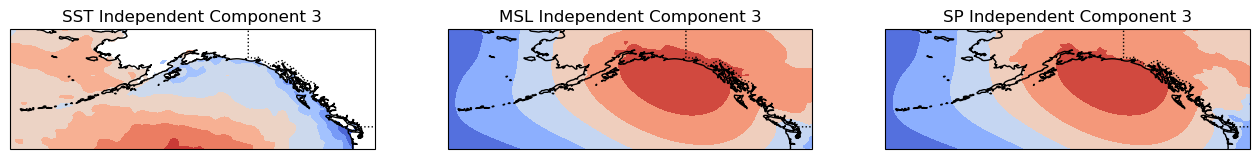

In [289]:
# loop through the EOFs
for j in range(3):

    ica = A_[:,j]

    # break out the eofs into different variables
    sst_ica_vector = np.reshape(ica[0:len_sst],(len_sst))
    sst_nan_vector = []
    cnt = 0
    for i in range(len(idx)):
        if idx[i]:
            sst_nan_vector.append(sst_ica_vector[cnt])
            cnt += 1
        else:
            sst_nan_vector.append(np.nan)
    sst_ica = np.reshape(np.array(sst_nan_vector),(n_lat,n_lon))
    msl_ica = np.reshape(ica[len_sst:len_sst+n_lat*n_lon],(n_lat,n_lon))
    sp_ica = np.reshape(ica[len_sst+n_lat*n_lon:],(n_lat,n_lon))

    ica_array = [sst_ica,msl_ica,sp_ica]
    labels = ['SST','MSL','SP']

    fig,ax = plt.subplots(1,3,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(16,30))
    

    for i in range(0,3):

        # make into xarray
        eof_xr = xr.DataArray(eof_array[i], coords=[lat, lon], dims=['latitude', 'longitude'])
        # plot the data
        ax[i].contourf(lon, lat, ica_array[i], cmap='coolwarm', transform=ccrs.PlateCarree())

        ax[i].set_xlabel('Longitude')
        ax[i].set_ylabel('Latitude')
        ax[i].add_feature(cfeature.COASTLINE)
        ax[i].add_feature(cfeature.BORDERS, linestyle=':')
        ax[i].set_title(labels[i]+f' Independent Component {j+1}')


    plt.show()

## Takeaways

I'm left with the impression that both ICA and PCA may have applications to this project. ICA pulls out strong, clear, and localized signals, and picks up on an overall climate change trend. However, PCA also picks up on strong patterns, and explains an impressive ~90% of variance with 3 PCs. I do think that the assumption of gausian data distrbutions is fair for this data, given the histograms in EDA.ipynb, and so PCA may be a suitable approach. The underlying proccesses which drive North Pacific climate are discussed in the literature, and many are known, another factor which might point us to favor PCA. That said, I'm looking for extreme winter storm anomalies which might drive the ice core record, and this signal may be highly non-gauissian. For the time being, I think I'll explore using both PCA and ICA timeseries in ML modeling.